In [1]:
import numpy as np
import matplotlib.pyplot as plt
import george
import emcee
import scipy.stats
import pandas as pd


from plotting import plot_mcmc_sampling_results

def prior(params):

    """
    Calculated the log of the prior values, given parameter values.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    param[0] : float
        mean (between 0 and 2)

    param[1] : float
        log amplitude (between -10 and 10)

    param[2] : float
        gamma (log gamma between 0.1 and 40)

    param[3] : float
        log period (period between 1h and 24hrs)

    Returns
    -------
    sum_log_prior : int
        sum of all log priors (-inf if a parameter is out of range)

    """

    p_mean = scipy.stats.norm(1, 0.5).logpdf(params[0])
    p_log_amp = scipy.stats.norm(np.log(0.15), np.log(2)).logpdf(params[1])
    p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    p_log_period = scipy.stats.norm(np.log(4./24.), (12./24.)).logpdf(params[3])

    sum_log_prior =  p_mean + p_log_amp + p_log_gamma + p_log_period

    if np.isnan(sum_log_prior) == True:
        return -np.inf

    return sum_log_prior


def logl(params, gp, tsample, fsample, flux_err):
     # compute lnlikelihood based on given parameters
     gp.set_parameter_vector(params)


     try:
         gp.compute(tsample, flux_err)
         lnlike = gp.lnlikelihood(fsample)
     except np.linalg.LinAlgError:
         lnlike = -1e25

     return lnlike


def post_lnlikelihood(params, gp, tsample, fsample, flux_err):

    """
    Calculates the posterior likelihood from the log prior and
    log likelihood.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    Returns
    -------
    ln_likelihood : float
        The posterior, unless the posterior is infinite, in which case,
        -1e25 will be returned instead.

    """

    # calculate the log_prior
    log_prior = prior(params)

    # return -inf if parameters are outside the priors
    if np.isneginf(log_prior) == True:
        return -np.inf

    try:
        lnlike = logl(params, gp, tsample, fsample, flux_err)
        ln_likelihood = lnlike+log_prior

    except np.linalg.linalg.LinAlgError:
        ln_likelihood = -1e25

    return ln_likelihood if np.isfinite(ln_likelihood) else -1e25


def read_data(filename, datadir="./"):
    """
    Read in light curve data from asteroid.
    """

    data  = pd.read_csv(datadir+filename, header=None, delim_whitespace=False)

    tsample = data[0]
    fsample = data[1]
    flux_err = data[2]

    return tsample, fsample, flux_err


class GPFit():
    def __init__(self, time_stamps, flux, flux_error):
        self.time = time_stamps
        self.flux = flux
        self.flux_err = flux_error
        self.data_pts = len(time_stamps)
        self.true_period = None
        self.params = None
        self.walker_params = None
        self.gp = None
        self.sampler = None

    def set_params(self):
        """Calculates initial gp parameter values based on data."""
        mean_flux = np.mean(self.flux)
        log_amp = np.log(self.flux.max()-self.flux.min())
        gamma = 1
        log_period = 0

        parameters = {"mean": mean_flux, "log_amp": log_amp, "gamma": gamma,"log_period": log_period}
        self.params = parameters
        return


    def set_walker_param_matrix(self, nwalkers):
        """Creates a matrix of starting parameters for every walker."""

        if self.params is not None:

            p_start = np.array(list(self.params.values()))
            cov_matrix = np.sqrt(np.diag(p_start)**2)
            p0 = np.random.multivariate_normal(mean=p_start, cov=cov_matrix, size=(nwalkers))

            # equally distributed starting period values
            p0[:,3] = np.log(np.linspace(2,12,nwalkers)/24.)

            self.walker_params = p0

        else:
            print("Please set parameter values first.")

        return

    def set_gp_kernel(self):
        """Sets up the Gaussian Process Kernel that is needed for george."""

        kernel = np.exp(self.params["log_amp"]) * george.kernels.ExpSine2Kernel(gamma = self.params["gamma"], log_period = self.params["log_period"])
        gp = george.GP(kernel, fit_mean=True, mean=self.params["mean"])
        gp.compute(self.time, self.flux_err)

        self.gp = gp

        return

    def run_emcee(self, nwalkers, niter, threads=1):
        """Runs emcee's mcmc code."""

        ndim = 4
        sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood, args=[self.gp, self.time, self.flux, self.flux_err], threads=threads)

        mcmc_sampling = sampler.run_mcmc(self.walker_params, niter)
        self.sampler = sampler

        return sampler

def main():

    # read in the data file
    time, flux, flux_err= read_data(filename, datadir)

    asteroid = GPFit(time, flux, flux_err)
    asteroid.set_params()
    asteroid.set_walker_param_matrix(nchain)
    asteroid.set_gp_kernel()

    sampler = asteroid.run_emcee(niter=niter, nwalkers=nwalkers, threads=threads)

    #plot_mcmc_sampling_results(np.array(asteroid.time), asteroid.flux, asteroid.flux_err,
    #                           asteroid.gp, sampler, namestr=filename + "_plots",
    #                           true_period=true_period)


    return

In [2]:
filename = "../data/simulation_results_new/221/221_lc_49627_to_49787.txt_sampled_dense_3days.txt"
datadir = "./"
nwalkers = 100
niter = 100
threads = 1

In [3]:
time, flux, flux_err= read_data(filename, datadir)

In [4]:
asteroid = GPFit(time, flux, flux_err)

In [5]:
asteroid.set_params()
asteroid.set_walker_param_matrix(nwalkers)
asteroid.set_gp_kernel()
gp = asteroid.gp

In [6]:
sampler = asteroid.run_emcee(niter=niter, nwalkers=nwalkers, threads=threads)

/home/christina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in log
/home/christina/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/christina/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


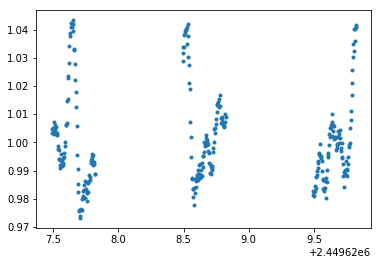

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(time, flux, '.')

In [23]:
t0 = time.min()

In [71]:
new_samples = sampler.chain
nsamples = new_samples.shape[0]
nsamples

100

In [88]:
tsample = np.array(time)
fsample = flux

In [192]:
nmodels = 10
npred = 1000
t_pred = None
idx = np.random.choice(np.arange(0, nsamples, 1, dtype=int), size=nmodels)
idx

array([82, 90,  9,  6, 62, 36, 98, 80, 93,  6])

In [194]:
# if the array for the predictions isn't given, make one
if t_pred is None:
    t_pred = np.linspace(tsample[0], tsample[-1], npred)
#print(t_pred)


In [195]:
# empty array for output
m_all = np.zeros((nmodels, t_pred.shape[0]))

In [196]:
for i,j in enumerate(idx):
        p = new_samples[j,-1]
        print(p)
        pnew = [p[0], p[1], p[2], p[3]]

        gp.set_parameter_vector(pnew)
        mean_model = gp.sample_conditional(fsample, t_pred)
        m_all[i] = mean_model

[ 0.99571003 -3.95973401  5.3630226   0.31631967]
[ 1.15336839 -3.46457776  4.98263278  0.32631357]
[ 1.22325219 -2.64780928  9.81360315 -0.83080174]
[ 1.0720929  -4.59429959  5.62163143 -0.83088074]
[  1.00786336  -7.37479553 105.05484762  -0.830147  ]
[ 0.9932709  -5.4517877   6.24582461 -0.83050773]
[ 1.02802187 -5.01507074  6.25738805  0.554403  ]
[ 0.8241093  -2.96790872  4.11588257  0.31451652]
[ 0.99501645 -1.74554655  9.06987708  0.44592877]
[ 1.0720929  -4.59429959  5.62163143 -0.83088074]


In [92]:
new_samples[56, -1]

array([ 0.98687239, -6.26027094, 96.08044185,  0.47496364])

In [16]:
new_samples = sampler.flatchain
nsamples = new_samples.shape[0]

In [18]:
np.linspace(sampler.iterations-1, nsamples-1, nmodels)

array([  99., 1199., 2299., 3399., 4499., 5599., 6699., 7799., 8899.,
       9999.])

In [7]:
sampler.iterations

100

In [15]:
new_samples

array([[ 0.36446652, -0.53500544, -0.0672289 , -2.48490665],
       [ 0.36446652, -0.53500544, -0.0672289 , -2.48490665],
       [ 0.36446652, -0.53500544, -0.0672289 , -2.48490665],
       ...,
       [ 0.43679369,  0.04770543,  2.57909172, -0.8303824 ],
       [ 0.40084306, -0.14643702,  2.56432885, -0.830333  ],
       [ 0.40084306, -0.14643702,  2.56432885, -0.830333  ]])

In [69]:
sampler.flatchain

array([[ 1.75434568, -1.60063842,  0.92057746, -2.48490665],
       [ 1.97692991, -1.59016621,  1.01055181, -2.76616114],
       [ 1.97692991, -1.59016621,  1.01055181, -2.76616114],
       ...,
       [ 0.99913255, -5.99377145, 62.57960688,  0.30716341],
       [ 1.00095827, -6.47226359, 77.41673191,  0.31451652],
       [ 1.00095827, -6.47226359, 77.41673191,  0.31451652]])

(array([65.,  0.,  0.,  0.,  0.,  2.,  0.,  3., 23.,  7.]),
 array([-8.31005453e-01, -6.92408122e-01, -5.53810791e-01, -4.15213460e-01,
        -2.76616129e-01, -1.38018798e-01,  5.78532502e-04,  1.39175863e-01,
         2.77773194e-01,  4.16370525e-01,  5.54967856e-01]),
 <a list of 10 Patch objects>)

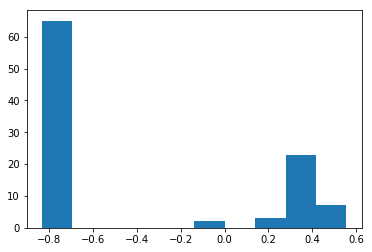

In [189]:
plt.hist(new_samples[:,-1,-1], bins =10)

In [190]:
periods = new_samples[:,-1,-1]

In [198]:
nsamples

100

In [191]:
periods.sort()
periods[idx]

array([-0.83100545, -0.83079913, -0.83061899, -0.83051758, -0.83045616,
       -0.83032225, -0.13549964,  0.31290806,  0.32281137,  0.55496786])

In [197]:
len(periods)

100

In [118]:
idx = np.rint(np.linspace(0,len(periods)-1, 10))

In [119]:
idx = idx.astype(int)

In [120]:
periods[idx]

array([-0.83100545, -0.83079913, -0.83061899, -0.83051758, -0.83045616,
       -0.83032225, -0.13549964,  0.31290806,  0.32281137,  0.55496786])

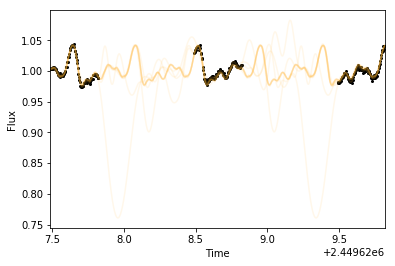

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

plot_lightcurve(tsample, fsample, true_lightcurve=None,
                    models=(t_pred, m_all), ax=ax)

In [12]:
from plotting import plot_lightcurve, plot_folded_lightcurve

In [162]:
print(models)

None


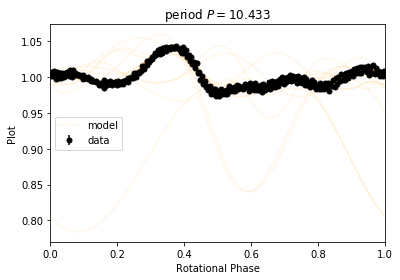

In [188]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax = plot_folded_lightcurve(tsample, fsample,10.433/24., flux_err=flux_err,
      models=[t_pred, m_all], true_lightcurve=None, ax=ax, use_radians=False)

In [183]:
true_period = 10.443*24.

In [148]:
guess_period = np.quantile(np.exp(sampler.chain[:,-1,-1]), 0.1)

In [149]:
guess_period

0.4357003657419736

In [9]:
10.433/24.

0.4347083333333333

[-0.72942042 -2.21133856  7.1203839  20.93295534]
[ 0.71988754 -3.76667519  5.0219338  21.00114712]
[ 0.7076027  -3.18114889  2.19722909 10.45609375]
[-0.09778804  7.12074701  4.73186209 31.75060403]
[ 0.89249478 -2.10691937  3.3493475  10.46566302]
[-9.62893197  2.00416563  7.11233349 38.46702935]
[ 1.67701683 -1.76944746  1.56941977  6.91195805]
[ 0.72889385 -1.89292617  3.44804027 10.45887988]
[ 1.63112201 -1.90441536  3.56579029 21.01095979]
[ 2.21657789 -1.42390541  2.39485262 20.92265641]


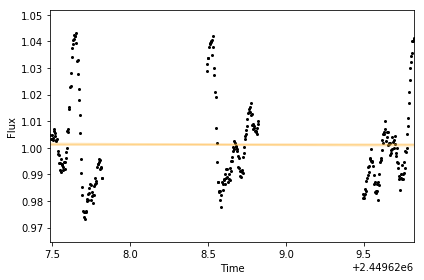

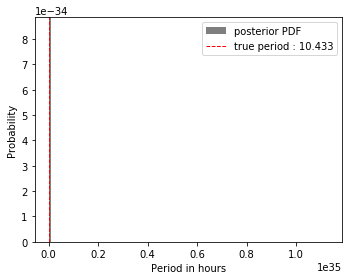

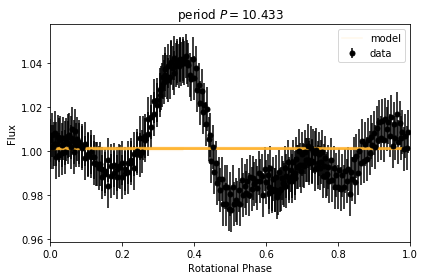

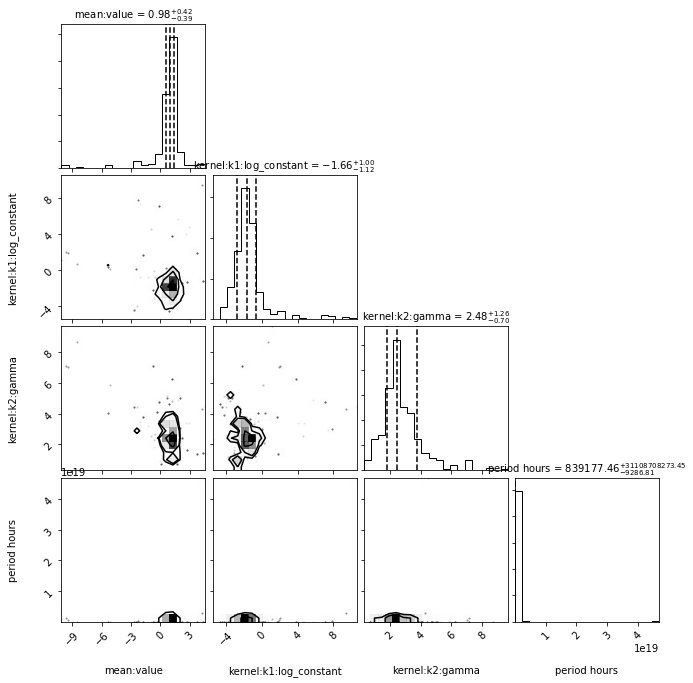

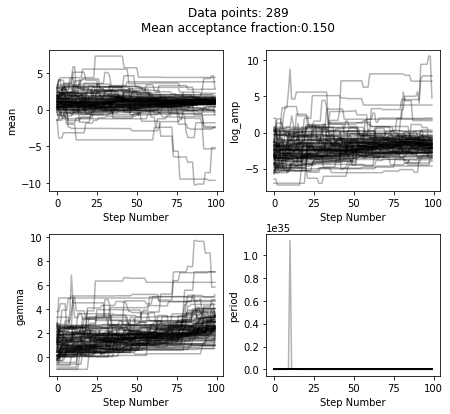

In [8]:
plot_mcmc_sampling_results(np.array(asteroid.time), asteroid.flux, asteroid.flux_err,
                           asteroid.gp, sampler, namestr=filename + "_plots",
                           true_period=10.433)

In [17]:
%load_ext autoreload
%autoreload 2

In [19]:
np.exp(sampler.chain[:,-1,-1])*24

array([1.04657932e+01, 2.08398502e+01, 1.56048871e+01, 1.57808575e-05,
       2.10026597e+01, 2.51980344e-01, 3.13786126e+01, 1.04628444e+01,
       1.04578152e+01, 1.04645769e+01, 6.91998026e+00, 3.13359667e+01,
       1.74080316e+01, 1.04620269e+01, 1.04617637e+01, 3.16757935e+01,
       2.09137243e+01, 1.04516627e+01, 1.36907625e+01, 1.07936808e+01,
       1.04652355e+01, 6.92205298e+00, 6.90780275e+00, 1.04582087e+01,
       1.04653939e+01, 6.91464202e+00, 1.04594312e+01, 2.10505418e+01,
       1.04590140e+01, 1.04581674e+01, 1.04584082e+01, 1.04684374e+01,
       2.09425845e+01, 1.03906560e+01, 6.92902554e+00, 1.04541362e+01,
       2.09359994e+01, 1.04426256e+01, 6.91273588e+00, 1.04589516e+01,
       3.34175255e+01, 1.04623611e+01, 1.04539607e+01, 1.04603385e+01,
       3.36816205e+01, 2.11661314e+01, 6.93888697e+00, 2.10297352e+01,
       6.94428925e+00, 2.09154341e+01, 1.04471471e+01, 1.04647392e+01,
       1.04571742e+01, 2.10052190e+01, 3.37192957e+01, 1.04615178e+01,
      

In [16]:
x = 3
y = copy.copy(x)

In [12]:
y = y*3

In [13]:
x

3

In [15]:
import copy